In [1]:
from glob import glob

import librosa as lb
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Define Paths

In [3]:
import pandas as pd
from glob import glob

# train.csv 파일 경로
csv_path = './data/train.csv'

# train 폴더 내의 파일 경로들
train_folder = './data/train/*'
train_files = glob(train_folder)

# CSV 파일 읽기
df = pd.read_csv(csv_path)

# 변수 초기화
real_audio = []
fake_audio = []

# 파일 경로에서 파일 이름만 추출하는 함수
def extract_filename(filepath):
    return filepath.split('/')[-1]

# train.csv에서 파일 경로와 레이블을 읽어와서 출력하는 예시
for index, row in df.iterrows():
    file_path = row['path']
    label = row['label']
    
    # 파일 경로에서 파일 이름 추출
    filename = extract_filename(file_path)
    
    # train 폴더에서 해당 파일 경로와 레이블 출력
    for file in train_files:
        if filename in file:
            if label == "real":
                real_audio.append(file)
            elif label == "fake":
                fake_audio.append(file)

# 결과 출력
print("Real Audio Files:")
for i, file in enumerate(real_audio):
    print(f"{i}: {file}")

print("\nFake Audio Files:")
for i, file in enumerate(fake_audio):
    print(f"{i}: {file}")

Real Audio Files:
0: ./data/train\RUNQPNJF.ogg
1: ./data/train\RDKEKEVX.ogg
2: ./data/train\QYHJDOFK.ogg
3: ./data/train\RSPQNHAO.ogg
4: ./data/train\ICDBLWYI.ogg
5: ./data/train\VCOXBYYG.ogg
6: ./data/train\CEQFAVNQ.ogg
7: ./data/train\RBOJKPRL.ogg
8: ./data/train\KWXWMDQK.ogg
9: ./data/train\RIVPTIUG.ogg
10: ./data/train\HHXDEAWG.ogg
11: ./data/train\VEKUNVOL.ogg
12: ./data/train\DUGQFOCW.ogg
13: ./data/train\IPTLQVGU.ogg
14: ./data/train\CNHKZJVI.ogg
15: ./data/train\GFGAWROI.ogg
16: ./data/train\WXTDXJYB.ogg
17: ./data/train\OLKZLSQZ.ogg
18: ./data/train\SZQZUAYE.ogg
19: ./data/train\NAPYTZSO.ogg
20: ./data/train\KDLMMZNV.ogg
21: ./data/train\CTSZQBDP.ogg
22: ./data/train\XEEYGMEM.ogg
23: ./data/train\HNJCYNPW.ogg
24: ./data/train\XVYSVGZO.ogg
25: ./data/train\QYZJWFGW.ogg
26: ./data/train\VUFXATFZ.ogg
27: ./data/train\CZGNMUYX.ogg
28: ./data/train\FDFVKKIW.ogg
29: ./data/train\BUSQUDYF.ogg
30: ./data/train\UGBJCTEY.ogg
31: ./data/train\GLVPNCRC.ogg
32: ./data/train\RWUSPUZQ.ogg
33

# Functions to get and plot Spectrograms and Mel Spectrograms
**Spectrogram:** A visual representation of the spectrum of frequencies in a signal as it varies with time, showing how the signal's frequency content changes over time.

**Mel Spectrogram:** A type of spectrogram where the frequencies are scaled according to the mel scale, which aligns more closely with human auditory perception, emphasizing perceptually relevant features.

**STFT (Short-Time Fourier Transform):** A mathematical technique used to analyze the frequency content of a signal as it changes over time. It divides a longer time signal into shorter segments of equal length and applies the Fourier transform to each segment. This provides a two-dimensional representation of the signal, with one dimension representing time and the other representing frequency.

In [4]:
def get_spectrogram(y: np.ndarray) -> (np.ndarray, int):
    '''
    Compute the spectrogram of an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.

    Returns:
    d (np.ndarray): Spectrogram of the audio signal, represented in decibels (dB).
    shape (tuple): Shape of the spectrogram (number of frequency bins, number of time frames).
    '''
    
    d = lb.stft(y)
    ad = lb.amplitude_to_db(np.abs(d), ref=np.max)
    
    return ad, ad.shape 

def plot_spectrogram(s: np.ndarray, sr: int = 22050, size: tuple=(8, 4), title: str = "Spectrogram of the Audio"):
    '''
    Plot a spectrogram.

    Parameters:
    s (np.ndarray): Spectrogram to plot. This should be a 2D array where the rows correspond to frequency bins and the columns correspond to time frames.
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (8, 4).
    title (str, optional): Title of the plot. Default is "Spectrogram of the Audio".
    '''
    
    plt.figure(figsize=size)
    lb.display.specshow(s, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()
    

In [5]:
def get_mel_spectrogram(y: np.ndarray, sr: int = 22050, n_mels: int = 128) -> (np.ndarray, int):
    '''
    Compute a Mel spectrogram from an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.
    sr (int): Sampling rate of `y`. 
    n_mels (int): Number of Mel bands to generate. 

    Returns:
    mel_spectrogram (np.ndarray): 2D array representing the Mel spectrogram.
    shape (tuple): Shape of the Mel spectrogram (number of Mel bands, number of frames).
    ''' 
    ms = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    m = lb.power_to_db(ms,ref=np.max) 
    
    return m, m.shape

def plot_mel_spectrogram(m: np.ndarray, sr: int = 22050, size: tuple = (8, 4), title: str = "Mel Spectrogram of Audio"):
    '''
    Plot a Mel spectrogram.

    Parameters:
    s (np.ndarray): Mel spectrogram to plot. 
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (8, 4).
    title (str, optional): Title of the plot. Default is "Mel Spectrogram of Audio".
    '''
    
    plt.figure(figsize=size)
    lb.display.specshow(m, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Real Audio Analysis

In [6]:
a, sr = lb.load(real_audio[1])
print(real_audio[1])

./data/train\RDKEKEVX.ogg


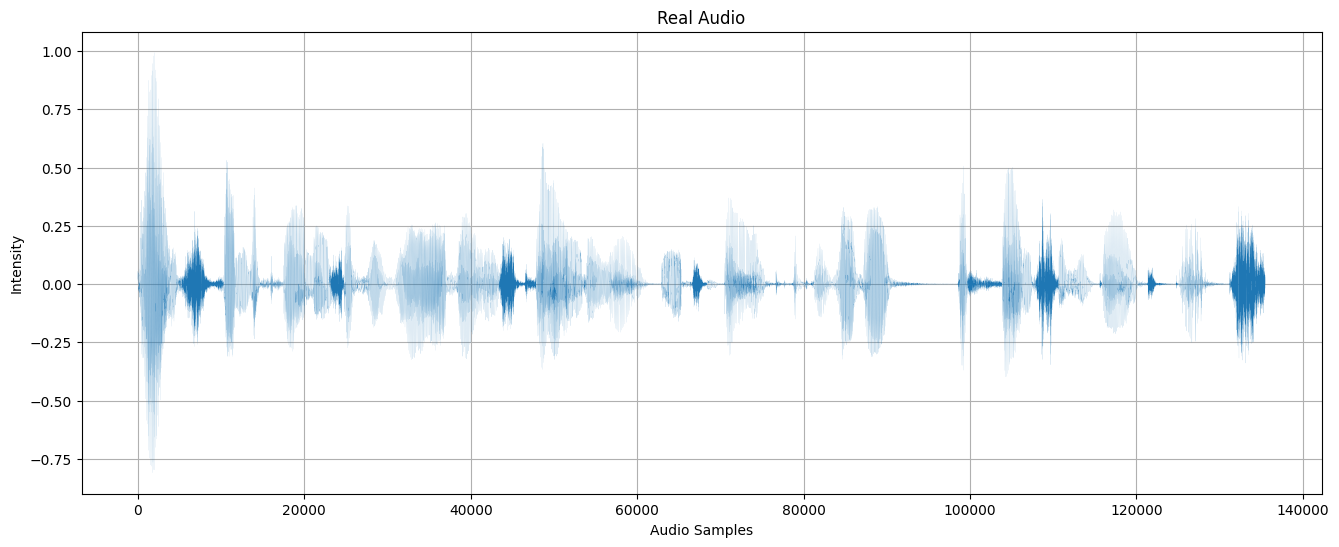

In [8]:
b = a[:400_000]

plt.figure(figsize=(16, 6))
plt.plot(b, lw=0.05)
plt.title("Real Audio")
plt.xlabel("Audio Samples")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

Dimension of spectrogram: (1025, 265)


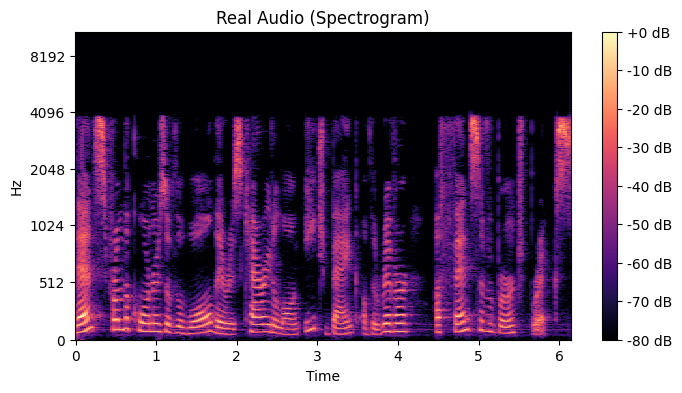

Dimension of mel spectrogram: (512, 265)


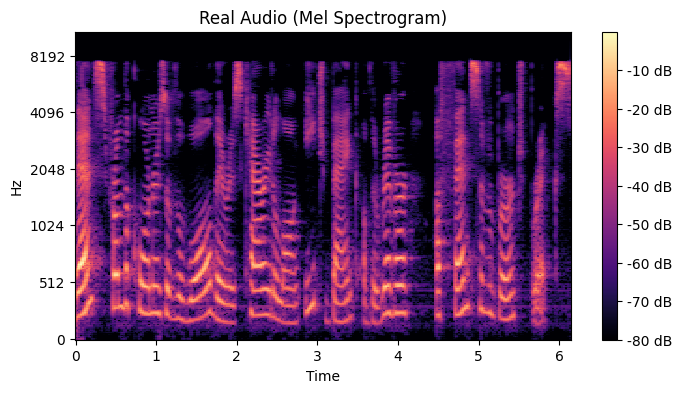

In [9]:
s1, s1_shape = get_spectrogram(y=b)
print(f"Dimension of spectrogram: {s1_shape}")

plot_spectrogram(s1, title="Real Audio (Spectrogram)")

m1, m1_shape = get_mel_spectrogram(y=b, n_mels=512)
print(f"Dimension of mel spectrogram: {m1_shape}")

plot_mel_spectrogram(m1, title="Real Audio (Mel Spectrogram)")

# Fake Audio Analysis

In [10]:
x, sr = lb.load(fake_audio[15])
print(fake_audio[15])

./data/train\VXRFNWTC.ogg


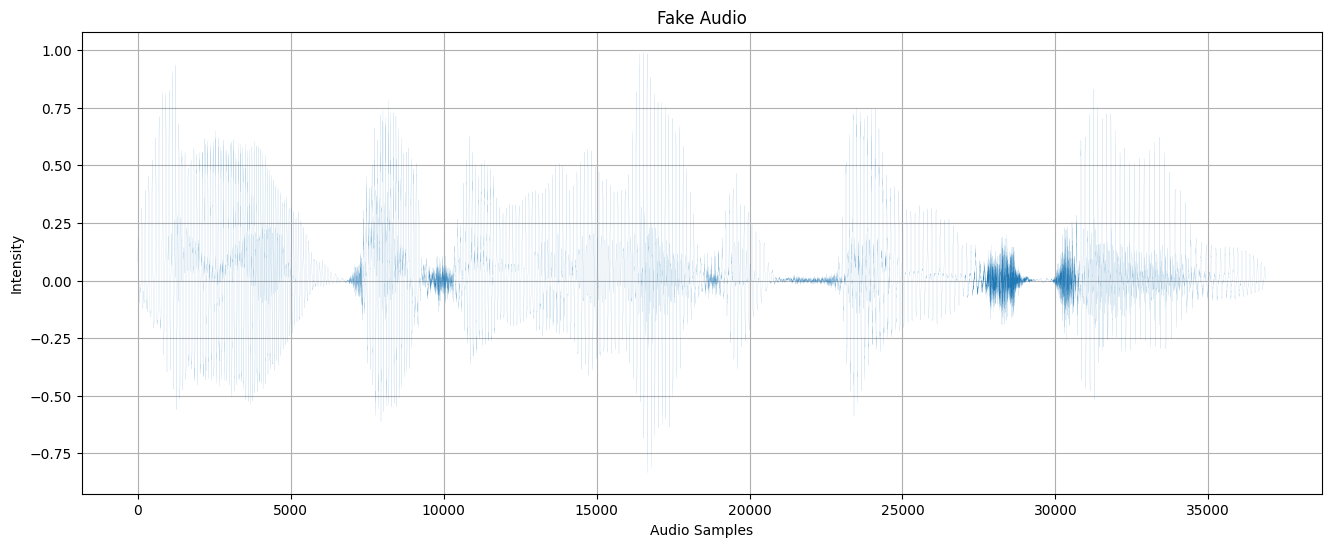

In [11]:
y = x[:400_000]

plt.figure(figsize=(16, 6))
plt.plot(y, lw=0.05)
plt.title("Fake Audio")
plt.xlabel("Audio Samples")
plt.ylabel("Intensity")
plt.grid(True)
plt.show()

Dimension of spectrogram: (1025, 72)


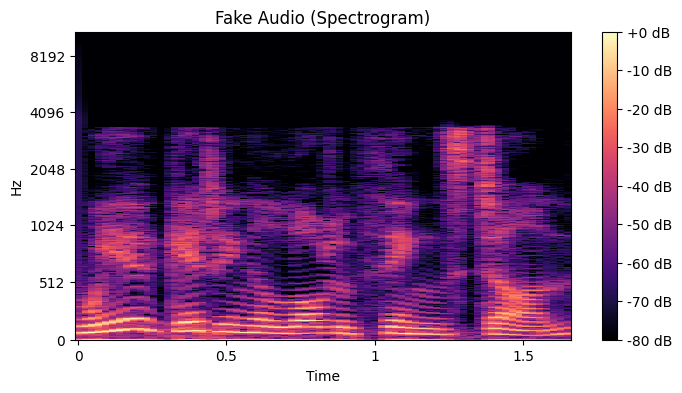

Dimension of mel spectrogram: (256, 72)


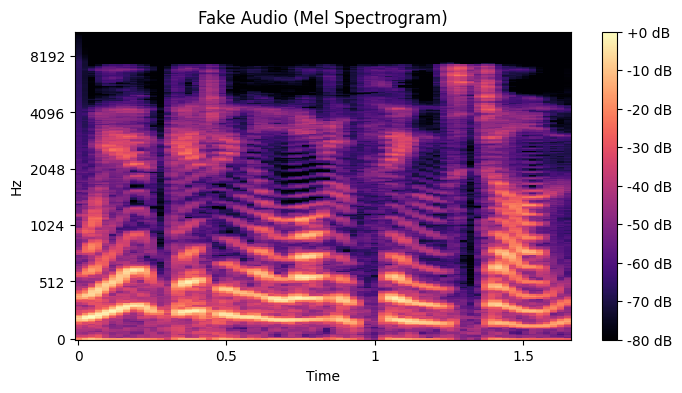

In [12]:
s2, s2_shape = get_spectrogram(y=y)
print(f"Dimension of spectrogram: {s2_shape}")

plot_spectrogram(s2, title="Fake Audio (Spectrogram)")

m2, m2_shape = get_mel_spectrogram(y=y, n_mels=256)
print(f"Dimension of mel spectrogram: {m2_shape}")

plot_mel_spectrogram(m2, title="Fake Audio (Mel Spectrogram)")

**Comparison between Mel Spectrograms of Real and Fake Audio**

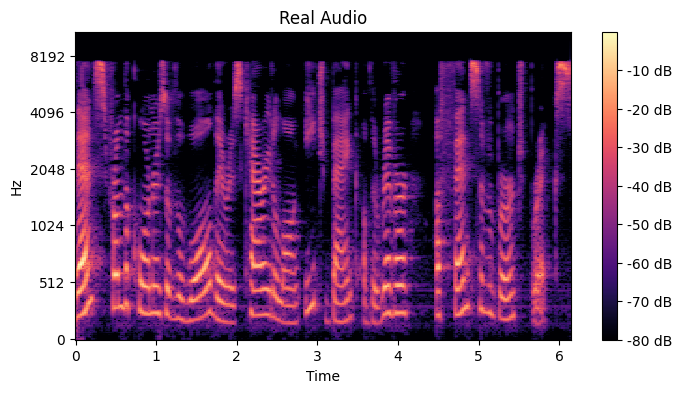

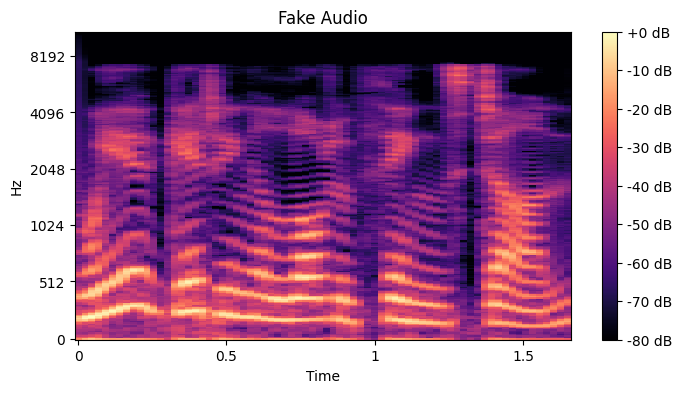

In [13]:
plot_mel_spectrogram(m1, title="Real Audio")
plot_mel_spectrogram(m2, title="Fake Audio")

# Function to create Mel Spectrogram samples (random) from audio

In [25]:
def create_mel_spectrogram_samples(y: np.ndarray, label: str|int, sr: int = 22050, samples: int = 10, sample_time: float = 3, n_mels: int = 128) -> (np.ndarray, np.ndarray):
    '''
    Generate multiple mel spectrogram samples from a single audio signal.

    Parameters:
    y (np.ndarray): The audio signal.
    label (str|int): The label for the samples.
    sr (int): Sampling rate of the audio signal (default is 22050 Hz).
    samples (int): Number of samples to generate (default is 10).
    time (float): Duration of each sample in seconds (default is 3).
    n_mels (int): Number of mel frequency bands (default is 128).

    Returns:
    samples (np.ndarray): Array of mel spectrogram samples.
    labels (np.ndarray): Array of labels containing the labels for the corresponding samples.
    '''
    
    import random
    import time
    
    begin = time.time()
    
    sample_length = int(sr * sample_time)
    s, l = [], []
    for _ in range(samples):
        start = random.randint(0, len(y) - sample_length)
        end = start + sample_length
        m, _ = get_mel_spectrogram(y[start: end], n_mels=n_mels)
        m = np.abs(m)
        m /= 80
        s.append(m)
        l.append([label])
    
    end = time.time()    
    
    print(f"...Sample created with label = '{label}' with {samples} samples | Dimension of mel spectrograms = {m.shape} | Time taken: {end-begin: .3f}s...")
    return np.array(s), np.array(l)

**Example Usage**

In [26]:
samples_real, label_real = create_mel_spectrogram_samples(y=a, label=1, samples=100, sample_time=1, n_mels=64)
samples_fake, label_fake = create_mel_spectrogram_samples(y=x, label=0, samples=100, sample_time=1, n_mels=64)

...Sample created with label = '1' with 100 samples | Dimension of mel spectrograms = (64, 44) | Time taken:  0.305s...
...Sample created with label = '0' with 100 samples | Dimension of mel spectrograms = (64, 44) | Time taken:  0.296s...


**Creating Training Data**

In [27]:
import random

combined_samples = []
combined_labels = []

for audio in real_audio:
    p, sr = lb.load(audio)
    s, l = create_mel_spectrogram_samples(y=p, label=0, samples=200, sample_time=1.5, n_mels=64)
    combined_samples.append(s)
    combined_labels.append(l)
    
for audio in random.choices(fake_audio, k=8):
    p, sr = lb.load(audio)
    s, l = create_mel_spectrogram_samples(y=p, label=1, samples=200, sample_time=1.5, n_mels=64)
    combined_samples.append(s)
    combined_labels.append(l)
    
combined_samples = np.concatenate(combined_samples, axis=0)
combined_labels = np.concatenate(combined_labels, axis=0)

...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.655s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  1.149s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.644s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.595s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.589s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.604s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.655s...
...Sample created with label = '0' with 200 samples | Dimension of mel spectrograms = (64, 65) | Time taken:  0.631s...
...Sample created with label = '1' with 

**Splitting**

In [28]:
print(f"Number of total samples: {combined_samples.shape[0]}")
print(f"Shapes of samples data and labels data: {combined_samples.shape} | {combined_labels.shape}\n")

X, X_test, y, y_test = train_test_split(combined_samples, combined_labels, test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

print(f"Shapes of train, validation and test data: {X_train.shape} | {X_val.shape} | {X_test.shape}")

Number of total samples: 3200
Shapes of samples data and labels data: (3200, 64, 65) | (3200, 1)

Shapes of train, validation and test data: (2304, 64, 65) | (576, 64, 65) | (320, 64, 65)


**Convolutional Neural Network model**

In [29]:
model = Sequential([
    Input((64, 65, 1)),
    
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.20),

    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256),
    Activation('relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.summary()

2024-06-21 16:01:49.996721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 16:01:50.255132: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 62, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,721 (2.47 MB)

 Trainable params: 646,401 (2.47 MB)

 Non-trainable params: 320 (1.25 KB)

**Training of the CNN**

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 'f1_score'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode="max")

history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6045 - f1_score: 0.6673 - loss: 1.2552 - val_accuracy: 0.4931 - val_f1_score: 0.6728 - val_loss: 0.7794
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7398 - f1_score: 0.6599 - loss: 0.5385 - val_accuracy: 0.4931 - val_f1_score: 0.6728 - val_loss: 0.8547
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7835 - f1_score: 0.6548 - loss: 0.4642 - val_accuracy: 0.4931 - val_f1_score: 0.6728 - val_loss: 1.0382
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8126 - f1_score: 0.6488 - loss: 0.4104 - val_accuracy: 0.5087 - val_f1_score: 0.6728 - val_loss: 0.7226
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8173 - f1_score: 0.6824 - loss: 0.3840 - val_accuracy: 0.5764 - val_f1_score: 0.6728 - val_loss: 0.6971
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8566 - f1_score: 0.6656 - loss: 0.3256 - val_accuracy: 0.5312 - val_f1_score: 0.6728 - val

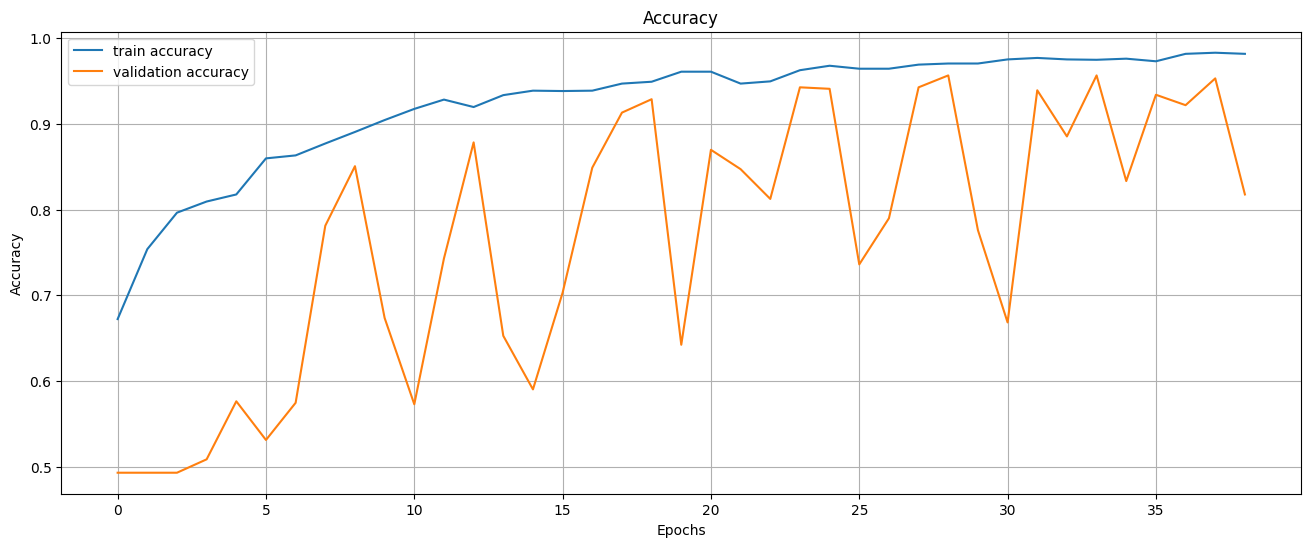

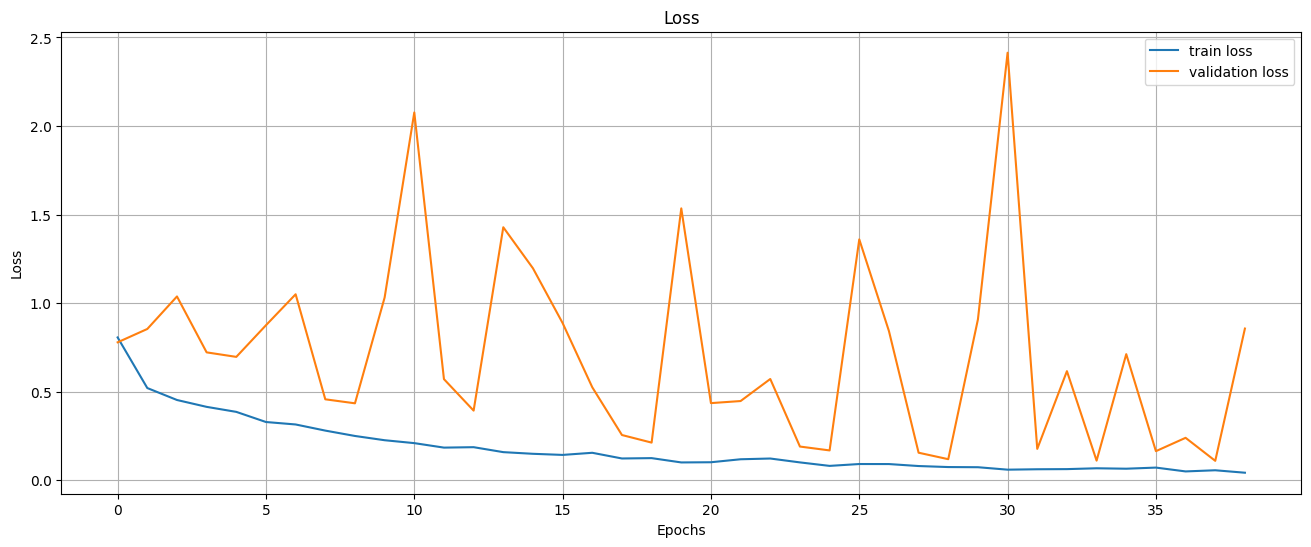

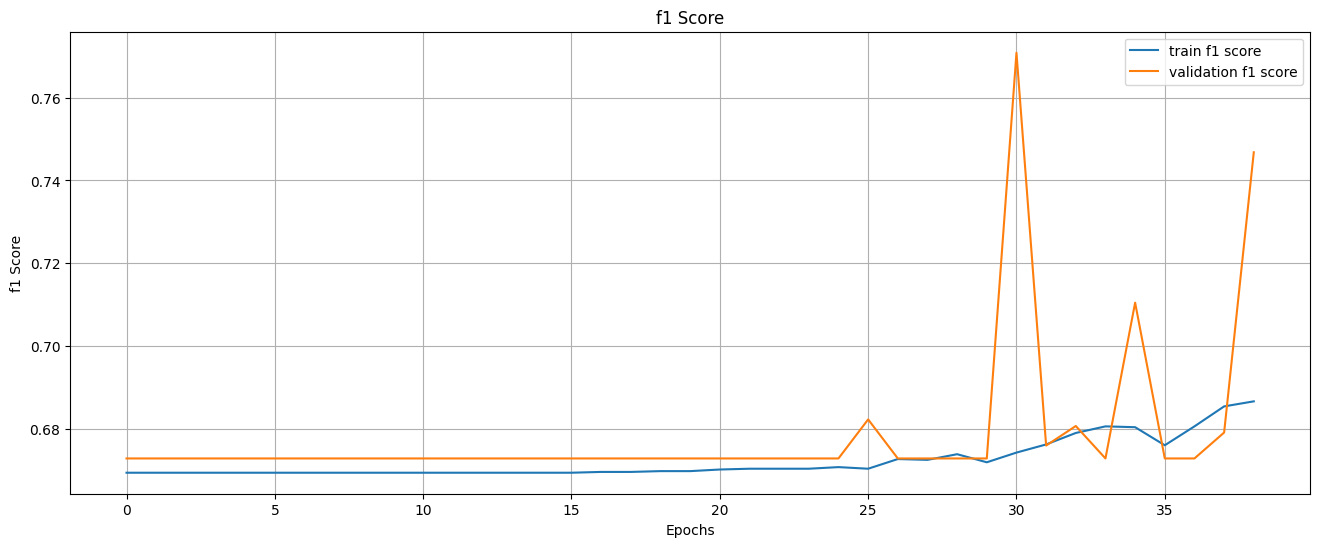

In [31]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

plt.figure(figsize=(16, 6))
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="validation accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="validation loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(train_f1, label="train f1 score")
plt.plot(val_f1, label="validation f1 score")
plt.title("f1 Score")
plt.xlabel("Epochs")
plt.ylabel("f1 Score")
plt.legend()
plt.grid(True)
plt.show()

# Testing the Model

**Testing**

In [32]:
from sklearn.metrics import accuracy_score

y_pred = np.round(model.predict(X_test))
val_acc = accuracy_score(y_pred, y_test)

print(f"Accuracy: {val_acc*100: .2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy:  97.19%


**Time Taken in Predictions (Performance Evaluation)**

In [33]:
%timeit -n 5 -r 2 model.predict(X_val)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
292 ms ± 12.5 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


**Model Saving**

In [36]:
model.save("./DeepFakeDetector_V1.h5") #Size = 7.83 MB (approx.)

# More Approaches

**MFCCs**

Mel-Frequency Cepstral Coefficients (MFCCs) are a set of features used in audio signal processing to represent the characteristics of speech and other audio signals. They are derived from the spectrum of the signal and are based on the human auditory system's response to different frequencies.

In [37]:
mfcc_1 = lb.feature.mfcc(y=b, sr=sr, n_mfcc=13)

print(mfcc_1.shape)
print(mfcc_1)

(13, 782)
[[-595.9384    -595.9384    -588.2771    ... -426.69293   -420.55893
  -427.84103  ]
 [   0.           0.          10.736561  ...  115.3771     111.67004
   109.4498   ]
 [   0.           0.          10.44682   ...   -4.164886    -9.043381
    -1.3907754]
 ...
 [   0.           0.           4.075679  ...    8.264694    11.875057
    11.851403 ]
 [   0.           0.           3.2387192 ...    3.396697     4.1530266
     2.0358634]
 [   0.           0.           2.4777074 ...    9.047393    11.102697
    13.270472 ]]


**Creating random mfcc samples from audio**

In [38]:
def create_mfcc_samples(y: np.ndarray, label: str|int, sr: int = 22050, samples: int = 10, sample_time: float = 3, n_mfcc: int = 13) -> (np.ndarray, np.ndarray):
    """
    Create MFCC samples from an audio signal.

    Parameters:
    y (np.ndarray): The input audio signal.
    label (str|int): The label associated with the audio signal.
    sr (int, optional): The sampling rate of the audio signal. Defaults to 22050.
    samples (int, optional): The number of samples to generate. Defaults to 10.
    sample_time (float, optional): The duration (in seconds) of each sample. Defaults to 3.
    n_mfcc (int, optional): The number of MFCCs to extract. Defaults to 13.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing:
        - An array of shape (samples, n_mfcc * sample_length) with the MFCC features for each sample.
        - An array of shape (samples, 1) with the corresponding labels.
    """
    
    import time
    import random
    
    begin = time.perf_counter()
    
    sample_length = int(sr * sample_time)
    s, l = [], []
    
    for _ in range(samples):
        start = random.start = random.randint(0, len(y) - sample_length)
        end = start + sample_length
        
        mfcc = lb.feature.mfcc(y=y[start:end], sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.flatten()
        
        mfcc = (mfcc - np.mean(mfcc))/np.std(mfcc)
    
        s.append(mfcc)
        l.append([label])
        
    end = time.perf_counter()
    
    print(f"...Sample created with label = '{label}' with {samples} samples | Dimension of mfcc (flattened) = {mfcc.shape} | Time taken: {end-begin: .3f}s...")
    
    return np.array(s), np.array(l)

In [39]:
import random

combined_samples = []
combined_labels = []

for audio in real_audio:
    p, sr = lb.load(audio)
    s, l = create_mfcc_samples(y=p, label=0, samples=100, sample_time=3, n_mfcc=13)
    combined_samples.append(s)
    combined_labels.append(l)
    
for audio in random.choices(fake_audio, k=8):
    p, sr = lb.load(audio)
    s, l = create_mfcc_samples(y=p, label=1, samples=100, sample_time=3, n_mfcc=13)
    combined_samples.append(s)
    combined_labels.append(l)
    
combined_samples = np.concatenate(combined_samples, axis=0)
combined_labels = np.concatenate(combined_labels, axis=0)

...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.604s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.552s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.653s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.541s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.640s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.552s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.552s...
...Sample created with label = '0' with 100 samples | Dimension of mfcc (flattened) = (1690,) | Time taken:  0.562s...
...Sample created with label = '1' with 100 samp

In [40]:
X_train, X_test, y_train, y_test = train_test_split(combined_samples, combined_labels, test_size=0.2, shuffle=True)

y_train = y_train.flatten()
y_test = y_test.flatten()
print(X_train.shape, X_test.shape)

(1280, 1690) (320, 1690)


**Using Support Vector Classifier**

In [41]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_model = svm.SVC(kernel='rbf', C=3)  
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 81.88%


In [42]:
%timeit -n 5 -r 3 svm_model.predict(X_test)

296 ms ± 17.6 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)


**Using Random Forest Classifiers**

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=400)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 81.25%


In [44]:
%timeit -n 10 -r 3 rf_model.predict(X_test)

34.7 ms ± 2.86 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


# Further Prospects

**1) Develop a standard sampler of audio (above ones are random)**

**2) Try more models and ensemble methods**

**3) Optimize Performance as much as possible by decreasing dimensions (Current record: 97% accuracy with CNN & 103 ms/320 samples ~ 0.31 ms/sample**